In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
! git clone https://github.com/metal3d/keras-video-generators.git

Cloning into 'keras-video-generators'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 614 (delta 47), reused 75 (delta 35), pack-reused 514
Receiving objects: 100% (614/614), 7.77 MiB | 30.58 MiB/s, done.
Resolving deltas: 100% (279/279), done.


In [ ]:
import os
# 다운로드한 폴더로 이동
os.chdir("/content/keras-video-generators/")

In [ ]:
# git 컴파일
! python setup.py build

/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'licence_file'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib
creating build/lib/keras_video
copying src/keras_video/__init__.py -> build/lib/keras_video
copying src/keras_video/utils.py -> build/lib/keras_video
copying src/keras_video/sliding.py -> build/lib/keras_video
copying src/keras_video/generator.py -> build/lib/keras_video
copying src/keras_video/flow.py -> build/lib/keras_video


In [ ]:
# 폴더 생성
! mkdir /content/keras_video
# git 파일 복사 /content/keras_video
! cp /content/keras-video-generators/build/lib/keras_video/*.*  /content/keras_video

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_video import VideoFrameGenerator
import sklearn
from tensorflow.keras.models import Sequential
from keras.applications import vgg16, vgg19
from tensorflow.keras.layers import TimeDistributed, GRU, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import keras_video.utils
from tensorflow_docs.vis import embed
import imageio

from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/X_train(5).npy')
y_train = np.load('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/y_train(5).npy')

In [ ]:
print(X_train.shape)
print(y_train.shape)

(356, 20, 224, 224, 3)
(356, 3)


### 비디오 증강

In [ ]:
# 데이터 경로
data_path = "/content/drive/MyDrive/cloud_ai/16.모듈프로젝트04/workspace/"

In [ ]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [ ]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [ ]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df=sklearn.utils.shuffle(train_df)

In [ ]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
290,v_TennisSwing_g15_c04.avi,TennisSwing,TennisSwing
230,v_Punch_g24_c06.avi,Punch,Punch
6,v_CricketShot_g08_c07.avi,CricketShot,CricketShot
66,v_CricketShot_g17_c04.avi,CricketShot,CricketShot
262,v_TennisSwing_g11_c04.avi,TennisSwing,TennisSwing
...,...,...,...
69,v_CricketShot_g18_c01.avi,CricketShot,CricketShot
340,v_TennisSwing_g23_c03.avi,TennisSwing,TennisSwing
167,v_Punch_g15_c02.avi,Punch,Punch
17,v_CricketShot_g10_c04.avi,CricketShot,CricketShot


In [ ]:
# tag에 저장된 라벨을 리턴
classes = train_df["tag"].unique().tolist()

In [ ]:
# 라벨 정렬
classes.sort()

In [ ]:
# 라벨 데이터 조회
classes

['CricketShot', 'Punch', 'TennisSwing']

In [ ]:
# train, validation data 분할
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
# 이미지 사이즈
SIZE = (224, 224)
CHANNELS = 3

In [ ]:
# 비디오 프레임의 이미지를 변형 할 객체 변형할 객체
train_image_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30, # 이미지 회전 각도 최대 30도
	zoom_range=0.15, # 이미지 확대 비율 
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전을 가능하도록 설정
	fill_mode="nearest", # 이미지를 회전 이동시 빈공간을 채우는 방식
)

In [ ]:
# 비디오 파일의 클래스 v_다음이 클래스임
glob_pattern=data_path+'train/v_{classname}_*.avi'

In [ ]:
# 비디오 프레임 20개 생성할 객체
train_video_generator = VideoFrameGenerator(
    classes=classes, # 분류할 클래스 설정 : ['CricketShot', 'Punch', 'TennisSwing']
    glob_pattern=glob_pattern, # 파일명에서 클래스 정보를 따옴
    nb_frames=20,              # 시퀀스의 프레임의 수 
    split=.33,                 # 검증용 파일로 나눌 분할 비율 
    shuffle=True,              # 섞을 것 인지 
    batch_size=2,              # 배치사이즈는 2로 설정 한 배치의 시퀀스 수
    target_shape=SIZE,         # 요소 2에서 만든 (224,224)
    nb_channel=CHANNELS,       # 요소 2에서 만든 3  3이니까 RGB 채널 
    transformation=train_image_data_gen, # 요소 3에서 만든 비디오 프레임의 변형 
    use_frame_cache=True       # 프레임 캐시를 사용할지 여부 / 사용을 위해 다량의 메모리 필요 
    )

Total data: 3 classes for 356 files for train


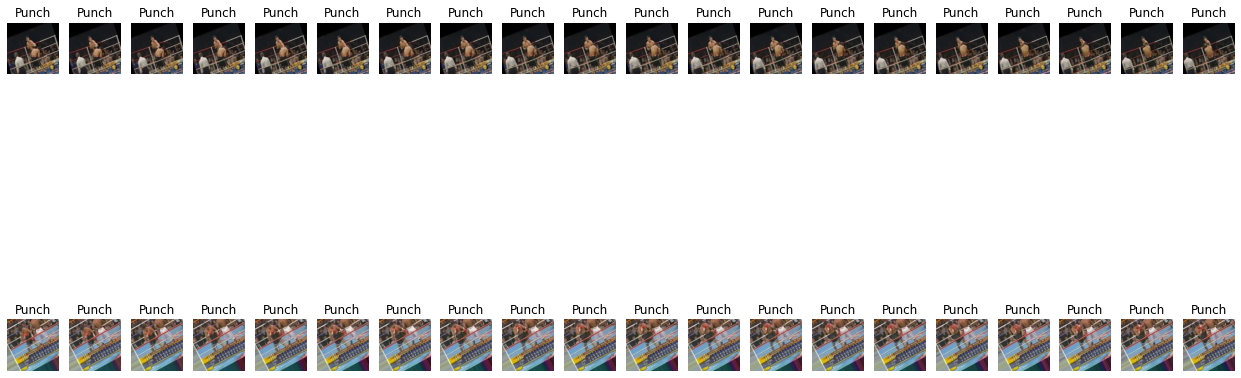

In [ ]:
# 비디오 프레임 샘플 데이터 조회 (배치사이즈 만큼)
keras_video.utils.show_sample(train_video_generator)

In [ ]:
model = Sequential()

In [ ]:

model.add(
    TimeDistributed(
        tf.keras.applications.VGG19(
        weights='imagenet'
        ,include_top=False
        ,input_shape=(224,224,3)
        )
        ,input_shape=(20,224,224,3)
    )
)

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(256, dropout=0.5))


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3, activation='softmax'))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 7, 7, 512)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 25088)         0         
_________________________________________________________________
gru (GRU)                    (None, 256)               19465728  
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [ ]:
model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)
                ,loss='categorical_crossentropy'
                ,metrics=['accuracy']
            )

gru_model = tf.keras.layers.GRU(
    units=(X_train/255).any(),
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False,
    reset_after=True # True
)

In [ ]:
# checkpoint 만들기
checkpoint_path = '/content/drive/MyDrive/4차 모듈 프로젝트_4조/model/tmp_checkpoint.ckpt'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path
    ,save_weights_only=True
    ,save_best_only=True
    ,monitor='val_loss'
    ,verbose=1
)

In [ ]:
# 이미지 학습
model.fit(
	train_video_generator
#	,X_train, y_train
	,batch_size=1
	,epochs=60 # lr : 1e-5
	,validation_data=(X_val, y_val)
	,callbacks=[checkpoint]
	,verbose=1
)

Epoch 1/50
178/178 [==============================] - 238s 1s/step - loss: 1.3549 - accuracy: 0.3539 - val_loss: 0.8723 - val_accuracy: 0.6742

Epoch 00001: val_loss improved from inf to 0.87226, saving model to /content/drive/MyDrive/4차 모듈 프로젝트_4조/model/tmp_checkpoint.ckpt
Epoch 2/50
178/178 [==============================] - 87s 486ms/step - loss: 1.1401 - accuracy: 0.4663 - val_loss: 0.7212 - val_accuracy: 0.7865

Epoch 00002: val_loss improved from 0.87226 to 0.72117, saving model to /content/drive/MyDrive/4차 모듈 프로젝트_4조/model/tmp_checkpoint.ckpt
Epoch 3/50
178/178 [==============================] - 87s 485ms/step - loss: 0.9349 - accuracy: 0.5478 - val_loss: 0.4581 - val_accuracy: 0.8876

Epoch 00003: val_loss improved from 0.72117 to 0.45808, saving model to /content/drive/MyDrive/4차 모듈 프로젝트_4조/model/tmp_checkpoint.ckpt
Epoch 4/50
178/178 [==============================] - 86s 484ms/step - loss: 0.7179 - accuracy: 0.6685 - val_loss: 0.3182 - val_accuracy: 0.9326

Epoch 00004: val_

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.save('/content/drive/MyDrive/4차 모듈 프로젝트_4조/model/VGG-19+GRU_cv,vg,cb(lr=1e5,ep=60).h5')

### test

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/4차 모듈 프로젝트_4조/model/VGG-19+GRU_cv,vg,cb(lr=1e5,ep=60).h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 7, 7, 512)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 25088)         0         
_________________________________________________________________
gru (GRU)                    (None, 256)               19465728  
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

### 비디오 증강

In [ ]:
X_test = np.load('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/X_test(5).npy')
y_test = np.load('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/y_test(5).npy')

In [ ]:
# 이미지 테스트
model.evaluate(
    X_test, y_test
    , batch_size = 8 # epochs=50
    # loss: 0.0292 - accuracy: 0.9944 - val_loss: 2.1187e-05 - val_accuracy: 1.0000
)

18/18 [==============================] - 32s 390ms/step - loss: 0.1111 - accuracy: 0.9562


[0.11110024154186249, 0.956204354763031]

### 임의의 영상으로 테스트 확인

In [ ]:
shuffled_test_df = pd.read_csv('/content/drive/MyDrive/4차 모듈 프로젝트_4조/data/shuffled_test.csv')
shuffled_test_df

,Unnamed: 0,video_name,tag,label
0,29,v_CricketShot_g05_c02.avi,CricketShot,0
1,92,v_TennisSwing_g01_c05.avi,TennisSwing,2
2,130,v_TennisSwing_g07_c01.avi,TennisSwing,2
3,101,v_TennisSwing_g02_c07.avi,TennisSwing,2
4,69,v_Punch_g05_c03.avi,Punch,1
...,...,...,...,...
132,125,v_TennisSwing_g06_c03.avi,TennisSwing,2
133,28,v_CricketShot_g05_c01.avi,CricketShot,0
134,66,v_Punch_g04_c05.avi,Punch,1
135,2,v_CricketShot_g01_c03.avi,CricketShot,0


In [ ]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
shuffled_test_df=sklearn.utils.shuffle(shuffled_test_df)

In [ ]:
# tag에 저장된 라벨을 리턴
classes = shuffled_test_df["tag"].unique().tolist()

In [ ]:
# 라벨 정렬
classes.sort()

In [ ]:
# 라벨 데이터 조회
classes

['CricketShot', 'Punch', 'TennisSwing']

In [ ]:
classes

['CricketShot', 'Punch', 'TennisSwing']

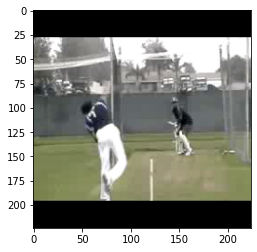

In [ ]:
# 0번째 비디오 프레임 이미지
plt.imshow(X_test[0][0])

In [ ]:
# 0번째 비디오 프레임 이미지
frame = X_test[90:91]
# 비디오 프레임 이미지의 종류 예측
predict01 = model.predict(frame)
print("predict01 = ", predict01)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
print("predict02 = ", predict02)
# 이미지의 종류 조회
text_predict = classes[predict02[0]]
print("text_predict=", text_predict)

predict01 =  [[4.0929754e-05 4.1672504e-07 9.9995863e-01]]
predict02 =  [2]
text_predict= TennisSwing


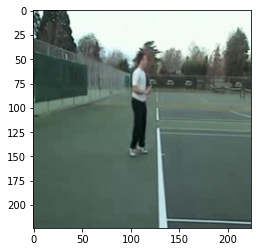

In [ ]:
# 0번째 비디오 프레임 이미지 image에 대입
image = frame[0][0].copy()
plt.imshow(image)

In [ ]:
# 이미지의 종류
str = "Activity :{}".format(text_predict)
# str을 출력할 이미지 좌표
org=(0,20) 
# 이미지 폰트
font=cv2.FONT_HERSHEY_PLAIN
# image에 str을 출력
cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)

array([[[0.21960784, 0.25490198, 0.30588236],
        [0.3137255 , 0.3529412 , 0.4       ],
        [0.2784314 , 0.3529412 , 0.38431373],
        ...,
        [0.95686275, 0.99607843, 0.972549  ],
        [0.95686275, 0.99607843, 0.972549  ],
        [0.95686275, 0.99607843, 0.972549  ]],

       [[0.10980392, 0.14901961, 0.2       ],
        [0.5764706 , 0.62352943, 0.6666667 ],
        [0.67058825, 0.74509805, 0.7764706 ],
        ...,
        [0.95686275, 0.99607843, 0.972549  ],
        [0.95686275, 0.99607843, 0.972549  ],
        [0.95686275, 0.99607843, 0.972549  ]],

       [[0.20784314, 0.3019608 , 0.31764707],
        [0.6117647 , 0.7058824 , 0.72156864],
        [0.5568628 , 0.6431373 , 0.6509804 ],
        ...,
        [0.95686275, 0.99607843, 0.972549  ],
        [0.95686275, 0.99607843, 0.972549  ],
        [0.95686275, 0.99607843, 0.972549  ]],

       ...,

       [[0.25490198, 0.32941177, 0.28627452],
        [0.25490198, 0.32941177, 0.28627452],
        [0.25490198, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


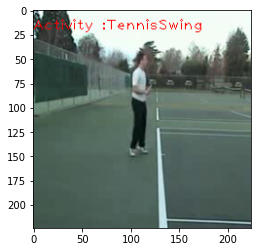

In [ ]:
# image에 str (영상 종류 예측값 ) 출력
plt.imshow(image)

In [ ]:
# 0으로 초기화된 [20,224,224,3 ] 배열 생성
images = np.zeros(shape=(20,224,224,3))
# X_test의 0번째 비디오
frame = X_test[0:1]
# 비디오  종류 예측
predict01 = model.predict(frame)
# 최고값이 있는 인덱스 조회
predict02 = np.argmax(predict01, axis=1)
# 이미지의 종류 조회
text_predict = classes[predict02[0]]
# 이미지의 종류
str = "Activity :{}".format(text_predict)
print("str = ", str)
for i in range(20):
    #frame 복사
    image = frame[0][i].copy()
    # str을 출력할 이미지 좌표
    org=(0,20) 
    # 이미지 폰트
    font=cv2.FONT_HERSHEY_PLAIN
    # image에 str을  출력
    cv2.putText(image,str,org,font, 1 ,(255,0, 0) , False)
    # images에 image 추가
    images[i] = image * 255

str =  Activity :CricketShot



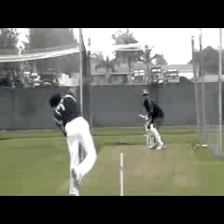

In [ ]:
# images를 정수로 변환
converted_images = images.astype(np.uint8)
# converted_images 를 animation.gif로 변환
imageio.mimsave("animation.gif", converted_images, fps=20)
# animation.gif 를 출력
embed.embed_file("animation.gif")